# Generative Adversarial Set Transformers

The following notebook provides a basic implementation of the GAST framework from the paper: *[Generative Adversarial Set Transformers](https://www.ml.informatik.tu-darmstadt.de/papers/stelzner2020ood_gast.pdf)*.


## Conversion Checklist

- [X] Use hinge-loss as described in the paper
- [X] Randomly sample the initial set
- [ ] Varying Set Cardinalities

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_addons as tfa
import time

from IPython import display

import dl_utils.tf as tf_utils
import settransformer as sf

import common

## Configuration

In [2]:
strategy = tf_utils.strategy("gpu:0")
# strategy = tf_utils.strategy(multi_gpu=True)

In [3]:
# Use the original implementation of multihead attention
# from the official Pytorch implementation of set transformer
sf.config("use_keras_mha", False)

False

## MNIST Dataset

Load the MNIST pointcloud dataset and set up the Tensorflow dataset.

In [4]:
# Point Clouds
# with np.load("./datasets/mnist_point_cloud_train_500.npz") as f:
#     x_train = f[list(f.keys())[0]]
# x_train = (x_train - np.mean(x_train)) / np.std(x_train)

In [7]:
window = (-3, 3) # preview viewport range
# BUFFER_SIZE = len(x_train)
BATCH_SIZE_PER_REPLICA = 32
GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

In [11]:
NUM_POINTS = 500
BUFFER_SIZE = 5

mnist_data_generator = common.MultiprocessMnistGenerator(
    batch_size=GLOBAL_BATCH_SIZE,
    num_points=NUM_POINTS,
    buffer_size=BUFFER_SIZE,
    num_workers=1,
    threshold=50)

train_dataset = tf.data.Dataset.from_generator(
    mnist_data_generator.generator,
    output_types=(tf.float32, tf.int32),
    output_shapes=(
        tf.TensorShape([GLOBAL_BATCH_SIZE, NUM_POINTS, 2]),
        tf.TensorShape([GLOBAL_BATCH_SIZE,])))

In [12]:
# train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(BUFFER_SIZE).batch(GLOBAL_BATCH_SIZE)
train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)

In [14]:
mnist_data_generator.start()

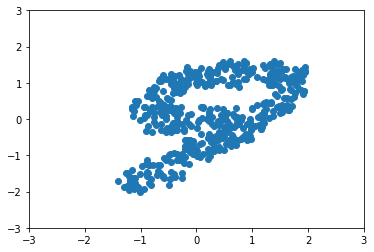

In [27]:
x_train = next(iter(train_dist_dataset))[0][0]
plt.scatter(*x_train.numpy().T)
plt.xlim(window)
plt.ylim(window)
plt.show()

## Layer Implementations

The following cells provide the layer implementations required for the GAST framework. The ISE layer specified in the paper has been implemented into the *set transformers* implementation as noted in the repository dependencies.

In [53]:
class ConditionedISAB(keras.layers.Layer):
    def __init__(self, embed_dim, dim_cond, num_heads, num_anchors):
        super(ConditionedISAB, self).__init__()
        self.embed_dim = embed_dim
        self.num_anchors = num_anchors
        self.mab1 = sf.MAB(embed_dim, num_heads)
        self.mab2 = sf.MAB(embed_dim, num_heads)
        self.anchor_predict = keras.models.Sequential([
            keras.layers.Dense(
                num_anchors*embed_dim,
                input_shape=(dim_cond,),
                activation="gelu"),
            tfa.layers.SpectralNormalization(
                keras.layers.Dense(num_anchors*embed_dim)),
            keras.layers.Reshape((num_anchors, embed_dim))
        ])
        
    def call(self, inp):
        inducing_points = self.anchor_predict(inp[1])
        h = self.mab1(inducing_points, inp[0])
        return self.mab2(inp[0], h)

In [54]:
class SampleSet(keras.layers.Layer):
    def __init__(self, max_set_size, embed_dim):
        super(SampleSet, self).__init__()
        self.max_set_size = max_set_size
        self.embed_dim = embed_dim
        
    def build(self, input_shape):
        self.mu = self.add_weight(
            shape=(self.max_set_size, self.embed_dim),
            initializer="random_normal",
            trainable=True,
            name="mu")
        self.sigma = self.add_weight(
            shape=(self.max_set_size, self.embed_dim),
            initializer="random_normal",
            trainable=True,
            name="sigma")
        
    def call(self, n):
        batch_size = tf.shape(n)[0]
#         n = tf.squeeze(tf.cast(n[0], dtype=tf.int32)) # all n should be the same, take one
        n = self.max_set_size
        mean = self.mu
        variance = tf.square(self.sigma)
        
        # Sample a random initial set of max size
        initial_set = tf.random.normal((batch_size, self.max_set_size, self.embed_dim), mean, variance)

        # Pick random indices without replacement
        _, random_indices = tf.nn.top_k(tf.random.uniform(shape=(batch_size, self.max_set_size)), n)        
        batch_indices = tf.reshape(tf.repeat(tf.range(batch_size), n), (-1, n))
        indices = tf.stack([batch_indices, random_indices], axis=2)
        
        # Sample the set
        sampled_set = tf.gather_nd(initial_set, indices)
        
        return sampled_set

## Model Architecture

![Model Architecture](./images/architecture.png)

In [75]:
NOISE_DIM = 64
EMBED_DIM = 64
LATENT_DIM = EMBED_DIM
NUM_HEADS = 4
NUM_ANCHORS = 24
MAX_SET_SIZE = x_train.shape[1]

### Generator

![Generator Transformer](./images/gen_layer.png)

In [76]:
with strategy.scope():
    y = x = keras.layers.Input((LATENT_DIM,))
    y = SampleSet(NUM_POINTS, EMBED_DIM)(y)
    y1 = ConditionedISAB(EMBED_DIM, LATENT_DIM, 4, 24)((y, x))
    y = keras.layers.Add()((y, y1))
    y1 = ConditionedISAB(EMBED_DIM, LATENT_DIM, 4, 24)((y, x))
    y = keras.layers.Add()((y, y1))
    y1 = ConditionedISAB(EMBED_DIM, LATENT_DIM, 4, 24)((y, x))
    y = keras.layers.Add()((y, y1))
    y = ConditionedISAB(EMBED_DIM, LATENT_DIM, 4, 24)((y, x))
    # y = keras.layers.Add()((y, y1))
    y = tfa.layers.SpectralNormalization(keras.layers.Dense(2, use_bias=False))(y)
    generator = keras.Model(x, y)
    generator.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 64)]         0                                            
__________________________________________________________________________________________________
sample_set_4 (SampleSet)        (None, 500, 64)      64000       input_14[0][0]                   
__________________________________________________________________________________________________
conditioned_isab_16 (Conditione (None, 500, 64)      2495488     sample_set_4[0][0]               
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
add_22 (Add)                    (None, 500, 64)      0           sample_set_4[0][0]        

## Discriminator

![Discriminator Transformer](./images/disc_layer.png)

In [77]:
with strategy.scope():
    y = x = keras.layers.Input((NUM_POINTS, 2))
    y1 = y = keras.layers.Dense(EMBED_DIM)(y)
    e0 = sf.ISE(1, LATENT_DIM, 4)(y)

    y = sf.ISAB(EMBED_DIM, num_heads=4, num_induce=32)(y)
    y1 = y = keras.layers.Add()((y1, y))
    e1 = sf.ISE(1, LATENT_DIM, 4)(y)

    y = sf.ISAB(EMBED_DIM, num_heads=4, num_induce=32)(y)
    y1 = y = keras.layers.Add()((y1, y))
    e2 = sf.ISE(1, LATENT_DIM, 4)(y)

    y = keras.layers.Concatenate()((e0, e1, e2))

    y = keras.layers.Dense(EMBED_DIM, activation="gelu", use_bias=False)(y)
    y = keras.layers.Dense(1, use_bias=False)(y)

    discriminator = keras.Model(x, y)
    discriminator.summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(None, 500, 2)]     0                                            
__________________________________________________________________________________________________
dense_360 (Dense)               (None, 500, 64)      192         input_15[0][0]                   
__________________________________________________________________________________________________
induced_set_attention_block_10  (None, 500, 64)      35328       dense_360[0][0]                  
__________________________________________________________________________________________________
add_25 (Add)                    (None, 500, 64)      0           dense_360[0][0]                  
                                                                 induced_set_attention_bloc

## Coupled Model

In [78]:
with strategy.scope():
    x = keras.layers.Input(generator.input_shape[1:])
    y = generator(x)
    y = discriminator(y)
    model = keras.Model(x, y)

## Loss Functions

Note: the original paper uses a version of Hinge loss. This implementation utilizes the basic binary crossentropy loss for the generator and discriminator.

In [79]:
with strategy.scope():
    loss_obj = keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)

In [80]:
def generator_loss(fake_output):
    loss = -tf.reduce_mean(fake_output)
    return loss / (1.0*GLOBAL_BATCH_SIZE)

def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(tf.maximum(1 - real_output, 0))
    fake_loss = tf.reduce_mean(tf.maximum(1 + fake_output, 0))
    loss = real_loss + fake_loss
    return loss / (1.0*GLOBAL_BATCH_SIZE)

## Optimizers

In [81]:
with strategy.scope():
    gen_optimizer = keras.optimizers.Adam(1e-4)
    disc_optimizer = keras.optimizers.Adam(4e-4)

## Training

It's worth noting that the generator conditions currently randomly samples points regardless of the given noise input. This causes generated preview digits to be inconsistant.

In [82]:
# @tf.function()
def train_step(pointclouds, k):
    for i in range(k):
        # batch noise
        noise = tf.random.normal((tf.shape(pointclouds)[0], LATENT_DIM))

        with tf.GradientTape() as disc_tape:
            gen_pointclouds = generator(noise)

            # Evaluate a batch of real and fake images against the discriminator
            real_output = discriminator(pointclouds, training=True)
            fake_output = discriminator(gen_pointclouds, training=True)
            
            disc_loss = discriminator_loss(real_output, fake_output)

        disc_grads = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        disc_optimizer.apply_gradients(zip(disc_grads, discriminator.trainable_variables))    
        
    # batch noise
    noise = tf.random.normal((2*tf.shape(pointclouds)[0], LATENT_DIM))
    
    discriminator.trainable = False
    with tf.GradientTape() as gen_tape:
        fake_output = model(noise, training=True)
        gen_loss = generator_loss(fake_output)
    gen_grads = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(gen_grads, generator.trainable_weights))
    discriminator.trainable = True
    
    return disc_loss, gen_loss
    
@tf.function()
def distributed_train_step(pointclouds, k):
    per_replica_losses = strategy.run(train_step, args=(pointclouds, k))
    return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)

In [83]:
# Used to preview during training
test_noise = tf.random.normal((4*6, LATENT_DIM))
disc_losses = []
gen_losses = []
epoch = 0
k = 3

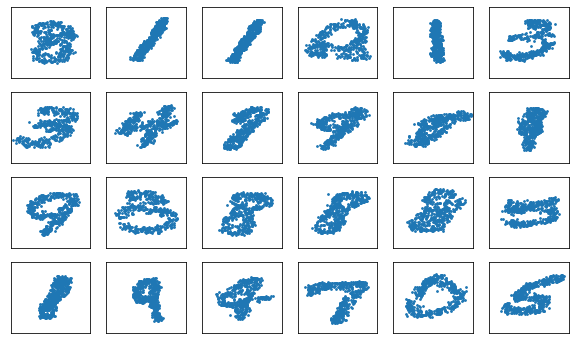

Epoch: 13; Batch: 530/1875

KeyboardInterrupt: 

In [84]:
# Training Loop
with strategy.scope():
    num_batches = int(60000 / GLOBAL_BATCH_SIZE)
    
    data_iterator = iter(train_dist_dataset)
    
    while True:
        
        start = time.time()
        
        # Display a preview
#         if epoch % 100 == 0:
        images = generator(test_noise)
        plt.figure(figsize=(10,6))
        for i, image in enumerate(images):
            x, y = tf.transpose(image)
            plt.subplot(4, 6, i+1)
            plt.scatter(x, y, s=3)
            plt.xticks([])
            plt.yticks([])
            plt.xlim(window)
            plt.ylim(window)
        plt.savefig(f"epochs/{epoch}.png")
        plt.show()

        disc_loss = 0
        gen_loss = 0
        for i in range(num_batches):
            batch = next(data_iterator)[0]
            losses = distributed_train_step(batch, k)
            disc_loss += losses[0]
            gen_loss += losses[1]
            print(f"\rEpoch: {epoch+1}; Batch: {i+1}/{num_batches}", end="")
        disc_losses.append(disc_loss / (i+1))
        gen_losses.append(gen_loss / (i+1))
        epoch += 1
        
        if epoch % 10 == 0:
            model.save_weights(f"gast_epoch_{epoch}.h5")
        
        display.clear_output(wait=True)
        tf.print(f"Epoch {epoch} completed in {time.time() - start:.2f} seconds. Generator loss: {gen_losses[-1]}; Discriminator loss: {disc_losses[-1]}", end="\r")

In [ ]:
plt.figure(figsize=(9,6))
for i, image in enumerate(images):
    x, y = tf.transpose(image)
    plt.subplot(4, 6, i+1)
    plt.scatter(x, y, s=3)
    plt.xticks([])
    plt.yticks([])
    plt.xlim(window)
    plt.ylim(window)

In [85]:
images = generator(test_noise)

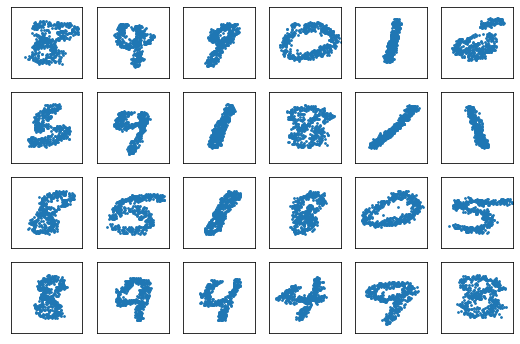

In [86]:
plt.figure(figsize=(9,6))
for i, image in enumerate(images):
    x, y = tf.transpose(image)
    plt.subplot(4, 6, i+1)
    plt.scatter(x, y, s=3)
    plt.xticks([])
    plt.yticks([])
    plt.xlim(window)
    plt.ylim(window)